<a href="https://www.kaggle.com/code/rasheedj/braintumourdetectormodel?scriptVersionId=236692125" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!gdown 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=2b823972-0c47-4b02-9a9f-f826a56c42d1
To: /kaggle/working/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:04<00:00, 36.7MB/s]


In [2]:

!unzip -q brain_tumor.zip

In [3]:
ls -l

total 152184
-rw-r--r-- 1 root root 155791278 Apr  5  2024 brain_tumor.zip
---------- 1 root root     35256 Apr 28 20:43 __notebook__.ipynb
drwxr-xr-x 6 root root      4096 Apr 28 20:43 Testing/
drwxr-xr-x 6 root root      4096 Apr 28 20:43 Training/


In [4]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab




The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 132 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (329 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
Selecting previously unselected package tree.
(Reading database ... 127365 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [6]:
# !tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

In [7]:
# Imports
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from glob import glob
import random

print('TensorFlow Version:', tf.__version__)

# Constants
IMG_DIMS = (224, 224)
BATCH_SIZE = 32
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
EPOCHS_HEAD = 10
EPOCHS_FINE = 30
RANDOM_SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Utils
def seed_everything(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

seed_everything(RANDOM_SEED)

# Dataset preparation
def prepare_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        "Training",
        validation_split=0.2,
        subset="training",
        seed=RANDOM_SEED,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        "Training",
        validation_split=0.2,
        subset="validation",
        seed=RANDOM_SEED,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        "Testing",
        seed=RANDOM_SEED,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )

    normalization_layer = layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds

TensorFlow Version: 2.17.0


In [8]:
# def create_normalization_layer():
#     """Create a normalization layer for the image data"""
#     normalization_layer = layers.Rescaling(1./255)
#     return normalization_layer

# def create_data_augmentation():
#     """Create a data augmentation pipeline appropriate for medical imaging"""
#     data_augmentation = keras.Sequential([
#         # More conservative augmentation appropriate for medical imaging
#         layers.RandomFlip("horizontal", input_shape=IMG_SHAPE),
#         layers.RandomRotation(0.05),  # Small rotation
#         layers.RandomZoom(0.05),      # Small zoom
#         layers.RandomContrast(0.05),  # Small contrast changes
#         layers.RandomBrightness(0.05) # Small brightness changes
#     ])
#     return data_augmentation

In [9]:
# Class weights
def get_class_weights(train_ds):
    labels = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
    labels = np.argmax(labels, axis=1)
    weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(enumerate(weights))

# Model
def build_model():
    base_model = ResNet50V2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.RandomFlip('horizontal')(inputs)
    x = layers.RandomRotation(0.02)(x)
    x = layers.RandomZoom(0.1)(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model, base_model

# Train
def train(model, base_model, train_ds, val_ds, class_weights):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
        ModelCheckpoint('models/best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    print("Stage 1: Training classifier head")
    history1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD, class_weight=class_weights, callbacks=callbacks)

    print("Stage 2: Fine-tuning full model")
    base_model.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )

    history2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE, class_weight=class_weights, callbacks=callbacks)

    return history1, history2

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Stage 1: Training classifier head
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6762 - loss: 2.3703 - precision: 0.7255 - recall: 0.6180
Epoch 1: val_accuracy improved from -inf to 0.86340, saving model to models/best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - accuracy: 0.6768 - loss: 2.3658 - precision: 0.7261 - recall: 0.6187 - val_accuracy: 0.8634 - val_loss: 0.9961 - val_precision: 0.8900 - val_recall: 0.8503 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8411 - loss: 0.9817 - precision: 0.8693 - recall: 0.8177
Epoch 2: val_accuracy improved from 0.86340 to 0.88354, saving model to models/best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.8411 

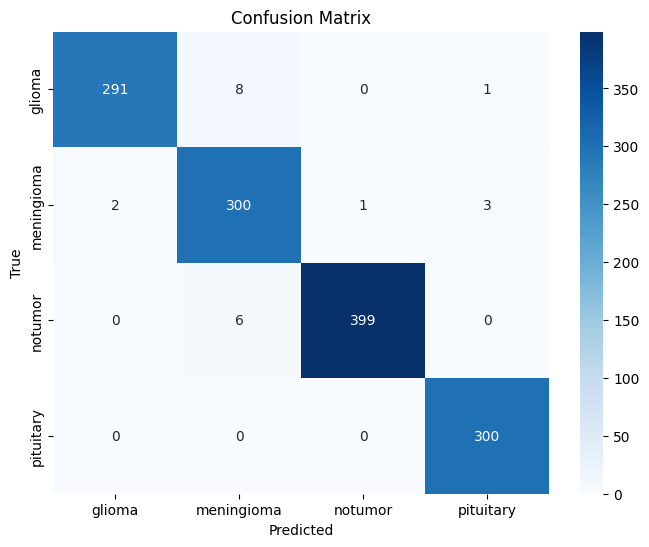

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.96      0.98      0.97       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [10]:
# Evaluation
def evaluate(model, test_ds):
    results = model.evaluate(test_ds)
    print(f"Test Results - Loss: {results[0]}, Accuracy: {results[1]}, Precision: {results[2]}, Recall: {results[3]}")

    y_true = []
    y_pred = []
    for images, labels in test_ds:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred, target_names=CLASSES))

# MAIN
def main():
    train_ds, val_ds, test_ds = prepare_datasets()
    class_weights = get_class_weights(train_ds)
    model, base_model = build_model()
    history1, history2 = train(model, base_model, train_ds, val_ds, class_weights)
    evaluate(model, test_ds)

if __name__ == "__main__":
    main()

In [11]:
# val_ds

In [12]:
# def prepare_datasets(show_samples=True):
#     """Prepare train, validation, and test datasets"""
#     # Data loading with proper preprocessing
#     normalization_layer = create_normalization_layer()
    
#     # Training dataset with validation split
#     train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#         "./Training",
#         validation_split=0.2,
#         subset="training",
#         seed=RANDOM_SEED,
#         image_size=IMG_DIMS,
#         batch_size=BATCH_SIZE,
#         label_mode='categorical'  # Use one-hot encoding
#     )
    
#     val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#         "./Training",
#         validation_split=0.2,
#         subset="validation",
#         seed=RANDOM_SEED,
#         image_size=IMG_DIMS,
#         batch_size=BATCH_SIZE,
#         label_mode='categorical'  # Use one-hot encoding
#     )
#         # Testing dataset
#     test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#         "./Testing",
#         seed=RANDOM_SEED,
#         image_size=IMG_DIMS,
#         batch_size=BATCH_SIZE,
#         label_mode='categorical'  # Use one-hot encoding
#     )
    
#     # Apply normalization
#     train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#     val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#     test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
    
#     # Use prefetching for better performance
#     AUTOTUNE = tf.data.experimental.AUTOTUNE
#     train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
#     val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
#     test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
    
#     # Calculate class weights to handle class imbalance
#     class_weights = calculate_class_weights(train_ds)
    
#     if show_samples:
#         show_sample_images(train_ds)
    
#     return train_ds, val_ds, test_ds, class_weights

In [13]:
# def calculate_class_weights(dataset):
#     """Calculate class weights for imbalanced dataset"""
#     # Count samples in each class
#     class_counts = [0] * len(CLASSES)
#     total_samples = 0
    
#     # Iterate through the dataset
#     for _, labels in dataset:
#         # Sum across batch dimension for each class
#         batch_sums = tf.reduce_sum(labels, axis=0).numpy()
        
#         # Add to class counts
#         for i, count in enumerate(batch_sums):
#             class_counts[i] += count
#             total_samples += count
    
#     # Calculate class weights inversely proportional to class frequency
#     class_weights = {}
#     for i, count in enumerate(class_counts):
#         if count > 0:
#             class_weights[i] = total_samples / (len(CLASSES) * count)
#         else:
#             class_weights[i] = 1.0
    
#     print("Class weights:", class_weights)
#     return class_weights

In [14]:

# def create_model():
#     """Create and compile the model with improved architecture"""
#     # Use ResNet50V2 which generally performs better than ResNet50
#     base_model = ResNet50V2(
#         input_shape=IMG_SHAPE,
#         include_top=False,
#         weights='imagenet'
#     )
    
#     # Freeze the base model initially
#     base_model.trainable = False
    
#     # Create data augmentation layers
#     data_augmentation = create_data_augmentation()
    
#     # Build the model
#     inputs = keras.Input(shape=IMG_SHAPE)
#     x = data_augmentation(inputs)
#     x = base_model(x, training=False)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.4)(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    
#     model = keras.Model(inputs, outputs)

      
#     # Compile the model
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#         loss=keras.losses.CategoricalCrossentropy(),
#         metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
#     )
    
#     return model, base_model


In [15]:

# def train_model(model, base_model, train_ds, val_ds, class_weights):
#     """Train the model with a two-stage approach: first train the head, then fine-tune"""
#     # Callbacks
#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         restore_best_weights=True,
#         verbose=1
#     )
    
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         min_lr=1e-6,
#         verbose=1
#     )
    
#     checkpoint = ModelCheckpoint(
#         'models/best_model.keras',
#         monitor='val_accuracy',
#         save_best_only=True,
#         verbose=1
#     )
    
#     # Stage 1: Train the head with base model frozen
#     print("Stage 1: Training the model head with base model frozen")
#     history_1 = model.fit(
#         train_ds,
#         epochs=10,
#         validation_data=val_ds,
#         class_weight=class_weights,
#         callbacks=[early_stopping, reduce_lr]
#     )
    
#     # Stage 2: Fine-tune the model by unfreezing the base model
#     print("Stage 2: Fine-tuning the entire model")
    
#     # Unfreeze the base model
#     base_model.trainable = True
    
#     # Recompile with a lower learning rate
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=1e-5),
#         loss=keras.losses.CategoricalCrossentropy(),
#         metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
#     )
    
#     # Train the entire model
#     history_2 = model.fit(
#         train_ds,
#         epochs=EPOCHS,
#         validation_data=val_ds,
#         class_weight=class_weights,
#         callbacks=[early_stopping, reduce_lr, checkpoint]
#     )
    
#     # Combine histories
#     combined_history = {}
#     for key in history_1.history:
#         combined_history[key] = history_1.history[key] + history_2.history[key]
    
#     return model, combined_history

In [16]:
# def evaluate_model(model, test_ds):
#     """Evaluate the model on the test dataset"""
#     # Evaluate the model
#     results = model.evaluate(test_ds, verbose=1)
#     print(f"Test loss: {results[0]:.4f}")
#     print(f"Test accuracy: {results[1]:.4f}")
#     print(f"Test precision: {results[2]:.4f}")
#     print(f"Test recall: {results[3]:.4f}")
    
#     # Get predictions and true labels
#     y_pred = []
#     y_true = []
    
#     for images, labels in test_ds:
#         predictions = model.predict(images)
#         y_pred.extend(predictions)
#         y_true.extend(labels.numpy())
    
#     y_pred = np.array(y_pred)
#     y_true = np.array(y_true)
    
#     # Convert one-hot to class indices
#     y_pred_classes = np.argmax(y_pred, axis=1)
#     y_true_classes = np.argmax(y_true, axis=1)
    
#     # Plot confusion matrix
#     plt.figure(figsize=(10, 8))
#     cm = confusion_matrix(y_true_classes, y_pred_classes)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
#     plt.title('Confusion Matrix')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.tight_layout()
#     plt.savefig('plots/confusion_matrix.png')
#     plt.show()
    
#     # Classification report
#     report = classification_report(y_true_classes, y_pred_classes, target_names=CLASSES)
#     print("Classification Report:")
#     print(report)
    
#     # Plot ROC curve for each class
#     plt.figure(figsize=(10, 8))
    
#     for i, class_name in enumerate(CLASSES):
#         # Calculate ROC curve
#         fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
#         roc_auc = auc(fpr, tpr)
        
#         # Plot ROC curve
#         plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve for Each Class')
#     plt.legend(loc='best')
#     plt.savefig('plots/roc_curve.png')
#     plt.show()
    
#     return y_true, y_pred



In [17]:

# def plot_training_history(history):
#     """Plot training history"""
#     plt.figure(figsize=(15, 5))
    
#     # Plot accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(history['accuracy'], label='Training Accuracy')
#     plt.plot(history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
    
#     # Plot loss
#     plt.subplot(1, 2, 2)
#     plt.plot(history['loss'], label='Training Loss')
#     plt.plot(history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.savefig('plots/training_history.png')
#     plt.show()

In [18]:
# def save_model(model, filename='brain_tumor_model.keras'):
#     """Save the model"""
#     model.save(f'models/{filename}')
#     print(f"Model saved to models/{filename}")

# def main():
#     """Main function to execute the entire pipeline"""
#     # Get class distribution
#     class_counts = get_class_distribution()
#     plot_class_distribution(class_counts)
    
#     # Prepare datasets
#     train_ds, val_ds, test_ds, class_weights = prepare_datasets()
    
#     # Create and train model
#     model, base_model = create_model()
#     model, history = train_model(model, base_model, train_ds, val_ds, class_weights)
    
#     # Plot training history
#     plot_training_history(history)
    
#     # Evaluate model
#     y_true, y_pred = evaluate_model(model, test_ds)
    
#     # Save model
#     save_model(model)
    
#     # Return trained model
#     return model

# # Execute the main function
# if __name__ == "__main__":
#     trained_model = main()

In [19]:
# from tensorflow.keras.models import load_model
# model = load_model('/kaggle/working/models/best_model.keras')

# # Assume you have a sample or batch of new data `X_test`
# # predictions = model.predict(test_ds)

# evaluate_model(model,test_ds)